In [45]:
from collections import defaultdict
import logging
logging.basicConfig(level=logging.DEBUG, format="%(asctime)s: (%(lineno)s) %(levelname)s %(message)s")
import os
import re

import json
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)
import pprint
import networkx as nx

from semeval_fca import find_paths_to_object

Populating the interactive namespace from numpy and matplotlib


# Freq cutoff

In [2]:
task_dir = '/mnt/permanent/Language/English/Data/SemEval/2018/Hypernym/'

In [82]:
freq_filen = os.path.join(task_dir, 'frequency_lists/1A_english_frequencylist.txt')
freqs = defaultdict(lambda: 1)
freqs.update({l.split("\t")[0]: int(l.split("\t")[1]) for l in open(freq_filen)})

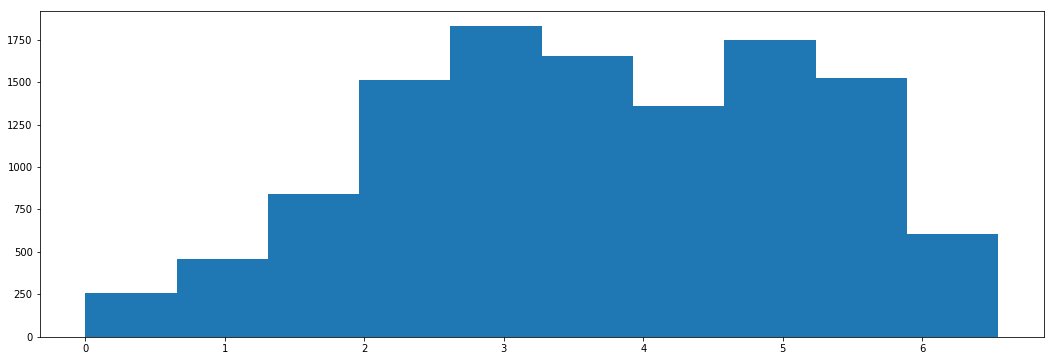

In [4]:
golds = [t for l in open(os.path.join(task_dir, 'main_data/training/gold/1A.english.training.gold.txt'))
         for t in l.strip().split('\t')]
plt.hist([0 if g not in freqs else np.log10(freqs[g]) for g in golds])
plt.show()

In [5]:
vocab = set([l.strip() for l in open(os.path.join(task_dir, 'main_data/vocabulary/1A.english.vocabulary.txt'))])

words_left = lambda x, threshold, vocabulary: [word for word, f in x.items() if f > threshold and word in vocabulary]



for threshold in [10, 100, 1000, 10000]:
    s = set(words_left(freqs, threshold, vocab))
    print('{}\t{}/{}\t{}/{}'.format(threshold, len(s), len(vocab), len([g for g in golds if g in s]), len(golds)))

10	135847/218753	11271/11780
100	76343/218753	10152/11780
1000	32219/218753	7661/11780
10000	9807/218753	5046/11780


# Tree exploration

In [6]:
logging.inf('')
J = json.load(open(
    '/mnt/store/hlt/Work/hypernym18-SemEval/concept_tree/1A_UMBC_tokenized.txt_100_sg.vec.gz_True_1000_0.2_unit_True_vocabulary_filtered_reduced.cxt.json'))
logging.inf('')

mind3 visszaadott lista olyan hosszú lesz, mint ahányféleképp el lehetett jutni a gyökérből egy olyan csúcsig, amiben megtalálható volt a lekérdezett szó

* a `path` ezeknek az utaknak a visszafejtését tartalmazza, 
* a `nodes` magát azt a csúcsot, ahol az i. út véget ért
* a `depths` pedig azt hogy a gyökértől milyen mélyen helyezkedik el ez a bizonyos csúcs


elvileg redundáns is, tehát a `paths` i. elemében egy olyan listát kell találj, ami egy gyökérben végződő utat kódol, és a `depths` i. értékéül épp ennek az útnak a hosszát kell lásd

In [59]:
def freq_based_print(words, max_len=6):
    items = sorted([(w, freqs[w]) for w in words], key=lambda it: it[1], reverse=True)
    ans = '  '.join('{} {:.2}'.format(
        re.sub(' ', '_', w),
        log10(f),) for w, f in items[:max_len])
    len_ = len(words)
    if len_ > max_len:
        ans += '... ({})'.format(len_)
    return ans

In [99]:
def print_path(query_word):#='dhow'
    """
    Prints pathes from the deepest (most specific) occurrence to the full set.
    """
    paths, nodes, depths = find_paths_to_object(J, query_word)
    logging.info(len(paths))
    max_depth = -1
    for path, node, depth in reversed(list(zip(paths, nodes, depths))):
        if depth < max_depth:
            break
        else:
            max_depth = depth
        print(
            #'dhow' in node, # == True 
            freq_based_print(node), depth)
        for node2 in path[:-1]:
            if len(node2['own_objects']):
                #print('{}\t{}\t{}'.format(my_print(node2['attributes']), node2['Node'], my_print(node2['own_objects'])))
                print('{}'.format(freq_based_print(node2['own_objects'])))#, max_len=11)))
            else:
                atts = 'attributes'
                print('{}: {} (no own object)'.format(atts, node2[atts]))
        print()


In [105]:
print_path('cowpox')

2018-01-23 17:08:25,043: (6) INFO 32


cowpox 2.5  erysipelas 2.3  skin_infection 0.0  spider_bite 0.0  insect_bite 0.0 4
corticosteroid 3.4  psoriatic 2.7  allodynia 2.0  arthrocentesis 1.9  periungual 1.6  metatarsalgia 1.4... (11)
plantar 3.0  meniscus 2.9  hydrogel 2.7  cosmesis 2.1  unfeathered 1.7  curet 1.1... (12)
hyperkeratosis 2.6  dapsone 2.5  ichthyosis 2.5  benzoyl 2.4  sulfoxide 2.4  triazole 2.1... (22)

cowpox 2.5  erysipelas 2.3  homeopathically 1.3 4
corticosteroid 3.4  psoriatic 2.7  allodynia 2.0  arthrocentesis 1.9  periungual 1.6  metatarsalgia 1.4... (11)
plantar 3.0  meniscus 2.9  hydrogel 2.7  cosmesis 2.1  unfeathered 1.7  curet 1.1... (12)
hyperkeratosis 2.6  dapsone 2.5  ichthyosis 2.5  benzoyl 2.4  sulfoxide 2.4  triazole 2.1... (22)

cowpox 2.5  erysipelas 2.3  inoculator 1.1  malignant_pustule 0.0 4
attributes: [984] (no own object)
corticosteroid 3.4  rhinitis 3.4  eczema 3.3  runny 3.3  thrush 3.2  angioedema 2.9... (74)
hyperkeratosis 2.6  dapsone 2.5  ichthyosis 2.5  benzoyl 2.4  sulfoxide

# Freq of hyper vs hypo

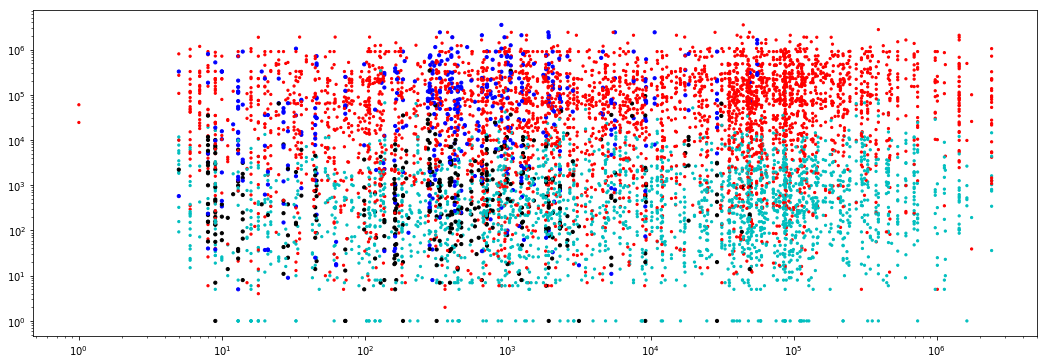

In [116]:
color_d = {
    (True, True): 'k',
    (True, False): 'b',
    (False, True): 'c',
    (False, False): 'r',
}


query_freqs, gold_freqs, colors, sizes = [], [], [], []
with open(os.path.join(task_dir, 'main_data/training/train.1A.by_freq')) as infile:
    for line in infile:
        query, freq, ent_conc, golds = line.strip().split('\t', maxsplit=3)
        for gold in golds.split('\t'):
            query_freqs.append(freqs[query])
            gold_freqs.append(freqs[gold])
            colors.append(color_d[' ' in query, ' ' in gold])
            sizes.append(10 if ' ' in query else 5)
          
            
plt.xscale('log')
plt.yscale('log')
plt.scatter(query_freqs, gold_freqs, c=colors, s=sizes)

In [13]:
depths[0]

1

# Lattice exploration

In [14]:
dag = nx.read_gpickle('/mnt/permanent/home/makrai/project/hypernym18-SemEval/top500words.gpickle')

In [16]:
dag.number_of_nodes(), dag.number_of_edges()

(196, 446)

In [17]:
print(dag.nodes['node175']['label'])

175|0th|n816\nn288\nn106\nn463\nn954\nn527\nn150\nn226\nn533\nn36
